In [190]:
import cortex
import cortex.polyutils
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import utils
# import helper_functions
# from helper_functions import readVerts
import os
opj = os.path.join
import plotly.io as pio
import cortex
pio.renderers.default="png"
list(pio.renderers)
from utils import *

In [191]:
#subjectid=['sub-001','sub-002','sub-003','sub-004','sub-005','sub-006','sub-007','sub-008','sub-009','sub-010','sub-011','sub-012','sub-013']
subjectid=['sub-001','sub-002','sub-003','sub-004','sub-005','sub-006','sub-008','sub-009','sub-010','sub-012','sub-013']
subject = subjectid
atlas = 'manual'
#model_name='nelder-mead_fithrf_2'
model_name='nelder-mead_v2_ups'
space='fsnative'
source='V1'
target_list=['V2','V3','V4','LO1','LO2']
use_venousmask=False
LOconcat=True
fssubject = 'fsnative'
project='CFLamUp'
denoising='nordic'
MAIN_PATH=f'/Users/mayra/Library/CloudStorage/OneDrive-UMCG/Postdoc/{project}/derivatives'

rois_list = np.array([['V1','V2', 'V3', 'V4', 'LO1', 'LO2'], [1, 2, 3, 4, 7, 8]])
rois = [['V1','V2', 'V3','V4', 'LO1', 'LO2']]
#depth_list=['0.0', '0.12', '0.25', '0.38','0.5', '0.62', '0.75', '0.88']
depth_list=['GM']

In [192]:
#plot fit results
import pickle

def load_CF_params(subject, denoising, atlas, model_name, depth_list,rois_list, source, target_list,target):
    best_fit=[]
    tc=[]
    thickness=[]
    pred_tc=[]

    #for r in range(len(target_list)):
    roi_name=rois[0][target]
    roi_idx = np.where(roi_name == rois_list[0, :])
    target_idx=np.where(rois_list[0]==target_list[target])
    target=rois_list[0][target_idx][0]
    try:
        best_fit_prf_lh = f'{MAIN_PATH}/CFM/{subject}/ses-1/GM/lh/{target}-{source}/best_fits_prf.csv'
        best_fit_prf_lh=pd.read_csv(best_fit_prf_lh)
    except:
        best_fit_prf_lh=pd.DataFrame([])
    try:
        best_fit_prf_rh = f'{MAIN_PATH}/CFM/{subject}/ses-1/GM/rh/{target}-{source}/best_fits_prf.csv'
        best_fit_prf_rh=pd.read_csv(best_fit_prf_rh)
    except:
        best_fit_prf_rh=pd.DataFrame([])

    best_fit_prf=pd.concat([best_fit_prf_lh,best_fit_prf_rh])
    best_fit.append(best_fit_prf)

    return best_fit

In [193]:
class CFmodel:
    def __init__(self, r2, CFsize, CFcenter_ecc, CFcenter_angle, depth,fs_idx, venous_mask):
        self.r2 = r2
        self.CFsize = CFsize
        self.CFcenter_ecc = CFcenter_ecc
        self.CFcenter_angle = CFcenter_angle
        self.depth = depth
        self.fs_idx = fs_idx
        self.venous_mask=venous_mask

In [194]:
class ROI:
    def __init__(self, roi_name, CFmodel, curve, curve_up, curve_low):
        self.roi_name=roi_name
        self.CFmodel=CFmodel
        self.curve=curve
        self.curve_up=curve_up
        self.curve_low=curve_low

In [196]:
def load_CFmodels(best_fit, depth_list,use_venousmask=False):
    CFmodels = []

    for d in range(depth_list.__len__()):
        CFmdl = CFmodel([],[],[],[],[],[],[])
        CFmdl.CFcenter_ecc = best_fit[0]['Source Eccentricity'].values
        CFmdl.CFcenter_angle = best_fit[0]['Source Polar Angle'].values
        CFmdl.CFsize = best_fit[0]['Best Sigma Finer'].values
        CFmdl.r2 = best_fit[0]['Best Variance Explained Finer'].values
        CFmdl.depth = depth_list[d]
        CFmdl.fs_idx = best_fit[0]['Target Vertex Index'].values
        if use_venousmask==True:
            pkl_file=opj(f'{MAIN_PATH}/venous_mask/{subject[s]}/ses-1/', f'{subject[s]}_desc-{depth_list[d]}_venous_mask.pkl')
            with open(pkl_file, 'rb') as input:
                pkl_data = pickle.load(input)
                venous_mask=pkl_data['venous_mask']
        else:
            venous_mask=np.ones_like(CFmdl.r2)
        CFmdl.venous_mask = venous_mask

        CFmodels.append(CFmdl)
    return CFmodels

In [197]:
def load_rois(subject, atlas):
    # In order to get the number of vertices in this subject's cortical surface
    # we have to load in their surfaces and get the number of points in each
    surfs = [cortex.polyutils.Surface(*d)
             for d in cortex.db.get_surf(subject, "fiducial")]

    fs_dirPATH=f'{MAIN_PATH}/freesurfer' #Bensons' labels need to be projected beforehand using neuropythy
    hemi=['RH','LH']

    idx_rois4, idx_vls4 = cortex.freesurfer.get_label(subject, label='benson14_varea-0001',
        fs_dir=fs_dirPATH,
        hemisphere=('lh', 'rh'),
        verbose=True)

    if atlas=='manual':
        idx_rois5, idx_vls5 = cortex.freesurfer.get_label(subject, label='manualdelin',
           fs_dir=fs_dirPATH,
          hemisphere=('lh','rh'),
          verbose=True)
        idx_vls4[idx_rois5]=idx_vls5
    return idx_vls4

In [198]:
class sub:
    def __init__(self,subject, denoising, atlas, model_name, depth_list, rois_list,source,target_list,use_venousmask=False):
        self.rois=[]
        idx_vls4=load_rois(subject,atlas) #get rois indexing
        # if venous_mask is not None:
        #     idx_vls4[venous_mask==0]=0
        for target in range(target_list.__len__()):
            best_fit=load_CF_params(subject,denoising,atlas,model_name,depth_list,rois_list, source, target_list,target)
            CFmodels=load_CFmodels(best_fit,depth_list,use_venousmask)
            roi=ROI(target_list[target],CFmodels,np.zeros((len(depth_list),)),np.zeros((len(depth_list),)),np.zeros((len(depth_list),)))
            #roi_name=rois[0][r]
            # roi_idx = np.where(roi_name == rois_list[0, :])
            # roi_verts = np.array(np.where(idx_vls4 == int(rois_list[1, roi_idx])))[0]
            # idx=np.in1d(best_fit[0]['Target Vertex Index'].values,roi_verts)
            for d in range(depth_list.__len__()):
                CFmodels[d].CFcenter_ecc, CFmodels[d].CFcenter_angle, CFmodels[d].CFsize, CFmodels[d].r2, CFmodels[d].fs_idx, CFmodels[d].venous_mask= \
                    [x for x in (CFmodels[d].CFcenter_ecc, CFmodels[d].CFcenter_angle, CFmodels[d].CFsize, CFmodels[d].r2,CFmodels[d].fs_idx, CFmodels[d].venous_mask)]
            self.rois.append(roi)

In [199]:
def mask_CFmodel(CFmodel,depth_list, r2_threshold, ecc_bound, CFsize_bound):
    #masking
    for d in range(depth_list.__len__()):
        idx_thr=np.ones_like(CFmodel[d].CFcenter_ecc, dtype=bool)
        idx_ecc1=CFmodel[d].CFcenter_ecc>ecc_bound[0]
        idx_ecc2=CFmodel[d].CFcenter_ecc<ecc_bound[1]
        idx_size1=CFmodel[d].CFsize>CFsize_bound[0]
        idx_r2=CFmodel[d].r2>=r2_threshold
        venous_mask=CFmodel[d].venous_mask>0
        idx_thr &= idx_ecc1 & idx_ecc2 & idx_size1 & idx_r2 & venous_mask
        CFmodel[d].CFcenter_ecc, CFmodel[d].CFcenter_angle,CFmodel[d].CFsize, CFmodel[d].r2,CFmodel[d].fs_idx,CFmodel[d].venous_mask = \
            [x[idx_thr] for x in (CFmodel[d].CFcenter_ecc, CFmodel[d].CFcenter_angle, CFmodel[d].CFsize, CFmodel[d].r2, CFmodel[d].fs_idx,CFmodel[d].venous_mask)]
    return CFmodel

In [200]:
SUBJECTS=[[] for s in range(subject.__len__())]
for s in range(subject.__len__()):
    SUBJECTS[s]=sub(subject[s],denoising,atlas,model_name,depth_list,rois_list, source, target_list, use_venousmask)

looking for ['/Users/mayra/Library/CloudStorage/OneDrive-UMCG/Postdoc/CFLamUp/derivatives/freesurfer/sub-001/label/lh.benson14_varea-0001.label', '/Users/mayra/Library/CloudStorage/OneDrive-UMCG/Postdoc/CFLamUp/derivatives/freesurfer/sub-001/label/rh.benson14_varea-0001.label']
looking for ['/Users/mayra/Library/CloudStorage/OneDrive-UMCG/Postdoc/CFLamUp/derivatives/freesurfer/sub-001/label/lh.manualdelin.label', '/Users/mayra/Library/CloudStorage/OneDrive-UMCG/Postdoc/CFLamUp/derivatives/freesurfer/sub-001/label/rh.manualdelin.label']
looking for ['/Users/mayra/Library/CloudStorage/OneDrive-UMCG/Postdoc/CFLamUp/derivatives/freesurfer/sub-002/label/lh.benson14_varea-0001.label', '/Users/mayra/Library/CloudStorage/OneDrive-UMCG/Postdoc/CFLamUp/derivatives/freesurfer/sub-002/label/rh.benson14_varea-0001.label']
looking for ['/Users/mayra/Library/CloudStorage/OneDrive-UMCG/Postdoc/CFLamUp/derivatives/freesurfer/sub-002/label/lh.manualdelin.label', '/Users/mayra/Library/CloudStorage/OneDri

# Concatenate LO-1 and LO-2, if desired

In [201]:
import numpy as np

# Function to concatenate matching properties of CFmodel from ROIs 3 and 4
def concatenate_LO(subject,depth, depth_list):
    # Access pRFmodel objects of ROIs 4 and 5
    cfmodel_roi3 = subject.rois[3].CFmodel[depth]
    cfmodel_roi4 = subject.rois[4].CFmodel[depth]

    # List to store concatenated properties
    concatenated_properties = {}

    # Get all attributes (properties) of pRFmodel (assuming both have the same attributes)
    properties = vars(cfmodel_roi3).keys()  # Use vars() to get property names

    # Iterate over all properties
    for prop in properties:
        if prop=='depth':
            concatenated_properties[prop] = depth_list[depth]
            continue
        # Get property values from both ROIs using getattr()
        prop_roi3 = getattr(cfmodel_roi3, prop)
        prop_roi4 = getattr(cfmodel_roi4, prop)

        # Concatenate the properties, handling both lists and arrays
        if isinstance(prop_roi3, np.ndarray) and isinstance(prop_roi4, np.ndarray):
            concatenated_properties[prop] = np.concatenate([prop_roi3, prop_roi4])
        elif isinstance(prop_roi3, list) and isinstance(prop_roi4, list):
            concatenated_properties[prop] = prop_roi3 + prop_roi4
        else:
            # Add other types of concatenations as needed
            raise TypeError(f"Unsupported type for concatenation: {type(prop_roi3)}")

    return concatenated_properties

# Usage Example
for s in range(SUBJECTS.__len__()):
    for d in range(depth_list.__len__()):
        concatenated_cfmodel = concatenate_LO(SUBJECTS[s],d, depth_list)
        # Create an instance for the concatenated values
        new_CFmodel = CFmodel([],[],[],[],[],[],[])

        # Assign concatenated properties to the new instance
        for key, value in concatenated_cfmodel.items():
            setattr(new_CFmodel, key, value)

        SUBJECTS[s].rois[3].CFmodel[d]=new_CFmodel
    SUBJECTS[s].rois[3].roi_name='LO'
    del SUBJECTS[s].rois[4]

rois_list = np.array([['V1','V2', 'V3', 'V4', 'LO'], [1, 2, 3, 4, 7]])
rois = [['V1','V2', 'V3','V4', 'LO']]
target_list=['V2','V3','V4','LO']

In [202]:
from numpy.polynomial import Polynomial
set_q3=0
r2_thr=0.1
ecc_bound=[0.1, 4.5]
CFsize_bound=[0.01,2]

sub-001
0
1176


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1
606


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2
333


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


3
860


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


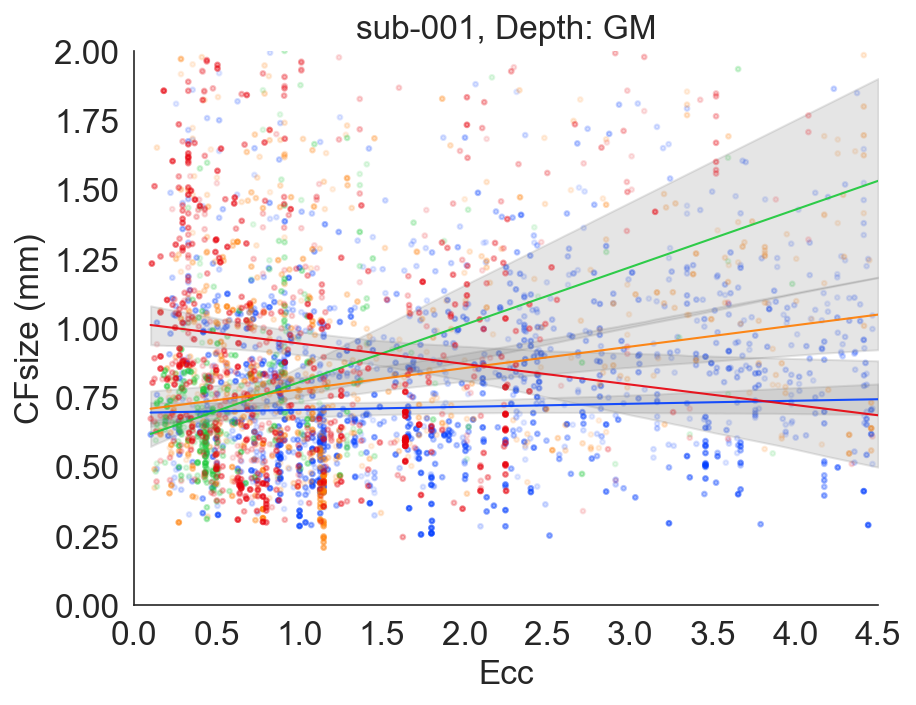

sub-002
0
2044


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1
887


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2
86


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


3
631


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


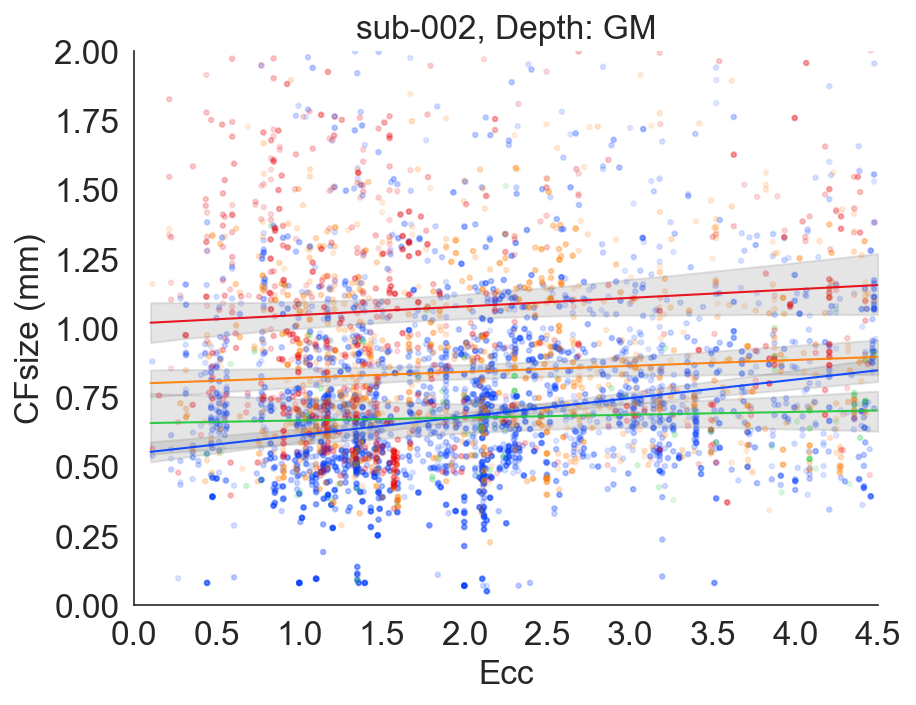

sub-003
0
2676


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1
1628


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2
311


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


3
330


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


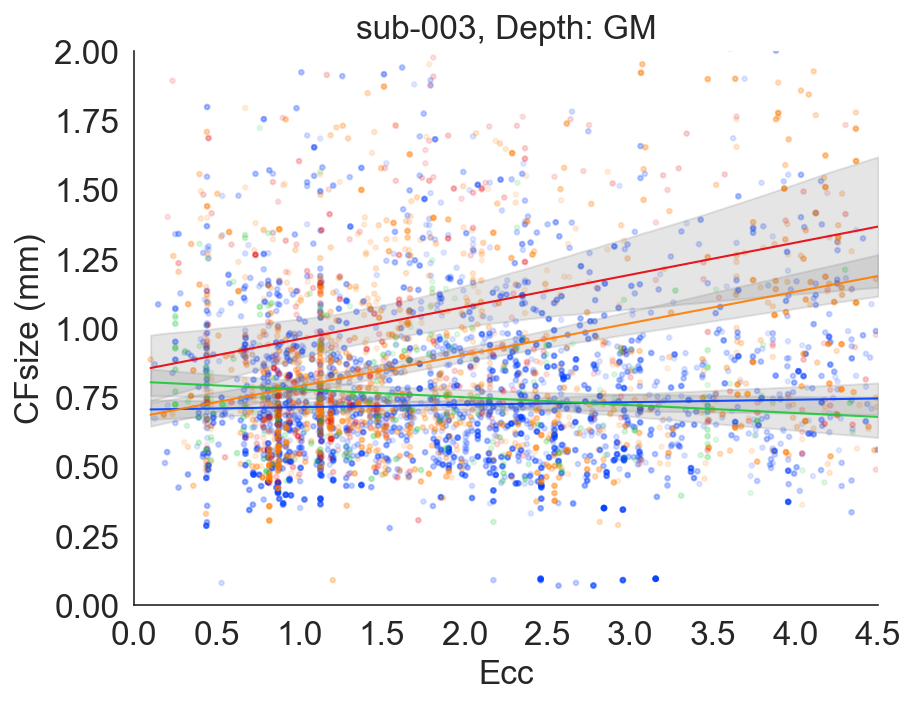

sub-004
0
3279


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1
1689


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2
271


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


3
961


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


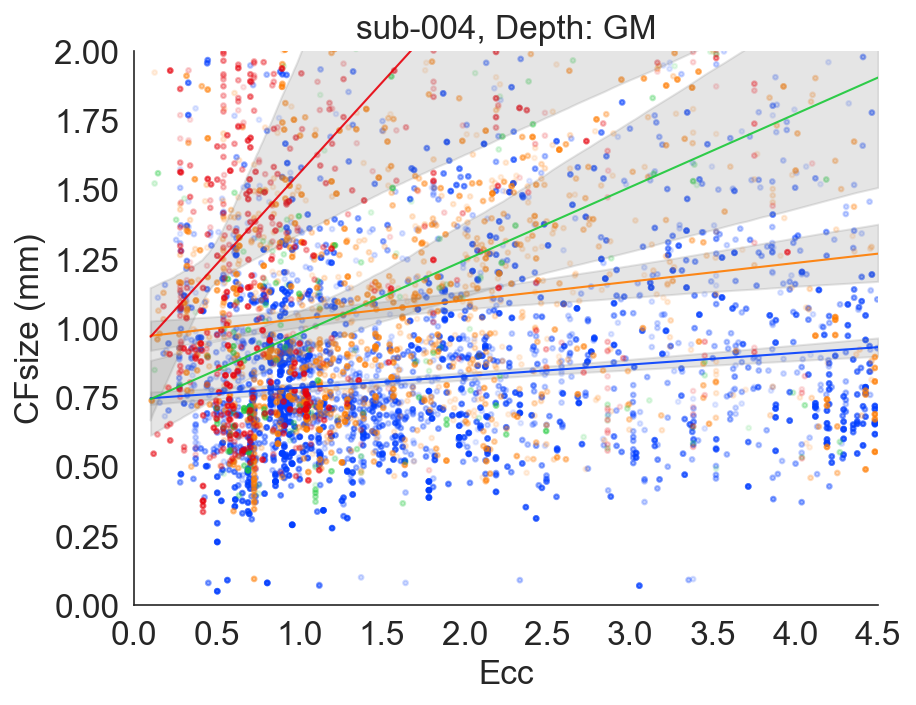

sub-005
0
746


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1
690


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2
329


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


3
434


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


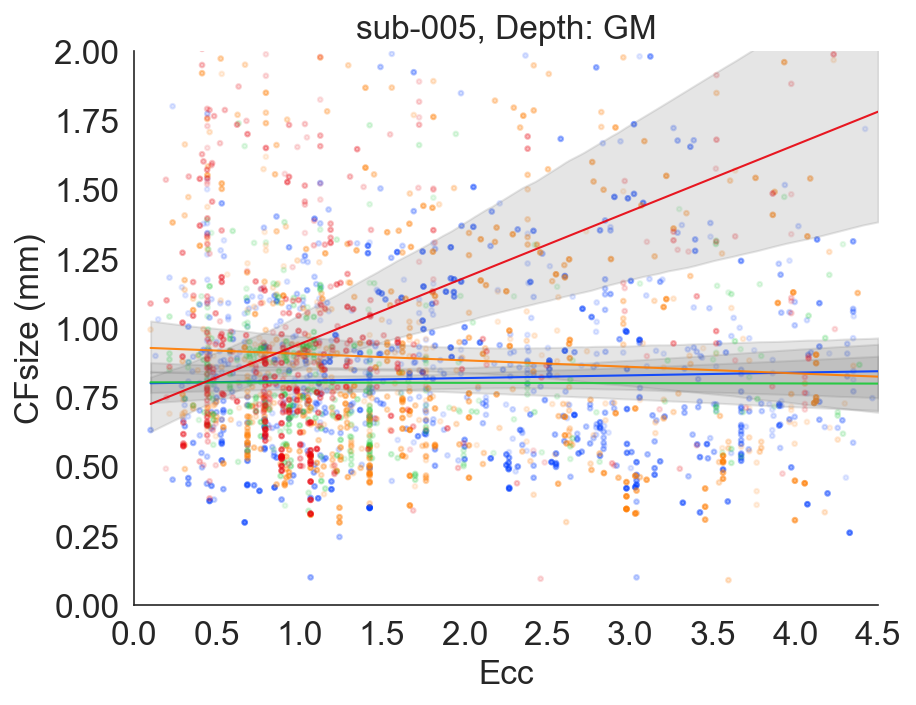

sub-006
0
1243


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1
1274


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2
116


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


3
773


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


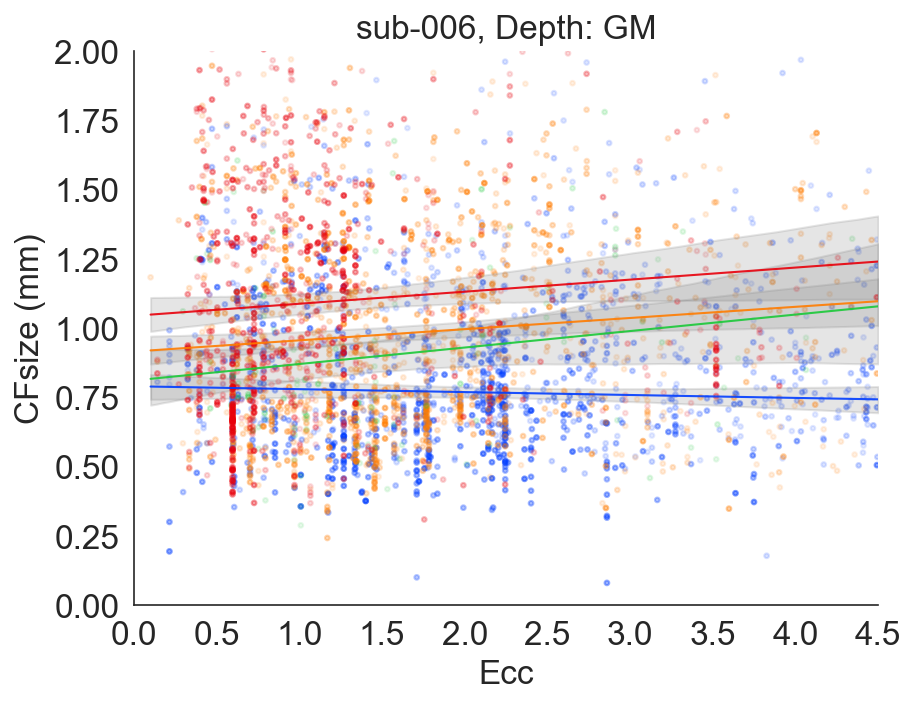

sub-008
0
2154


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1
1440


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2
154


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


3
438


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


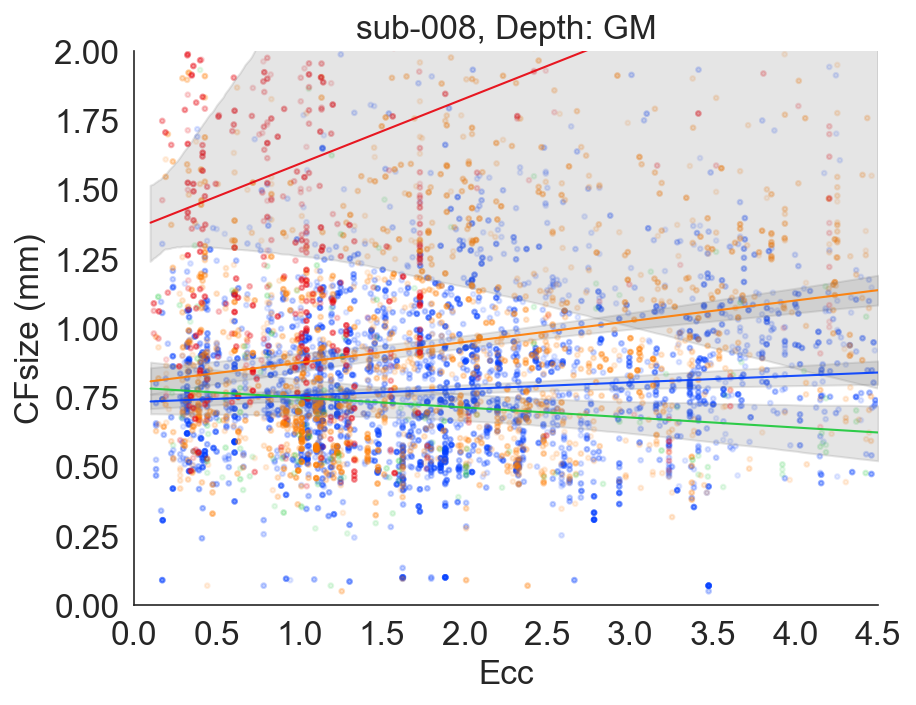

sub-009
0
1286


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1
569


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2
221


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


3
418


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


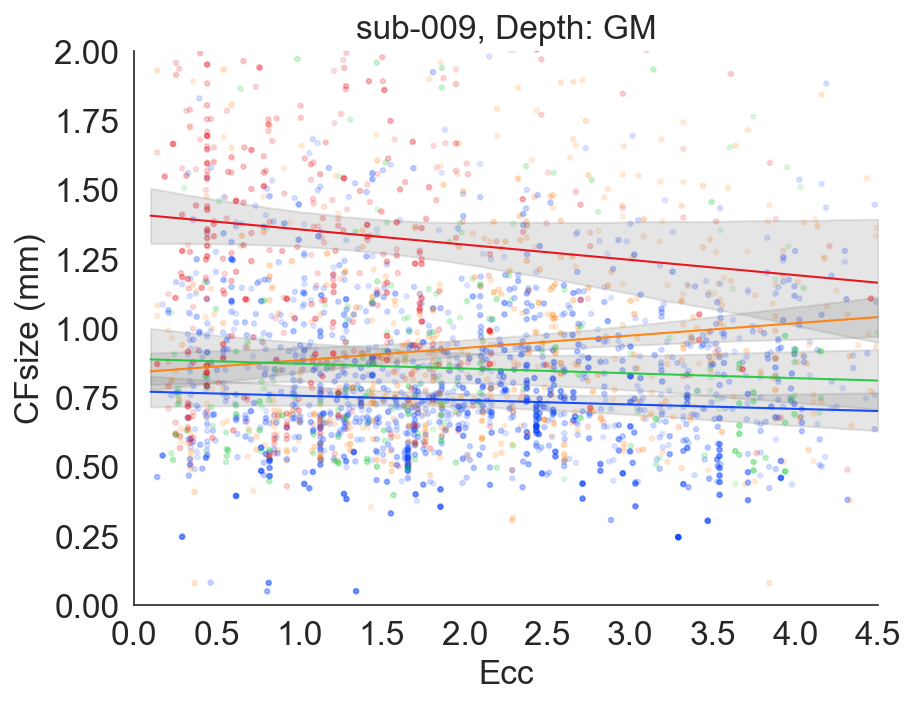

sub-010
0
1121


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1
1020


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2
141


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


3
345


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


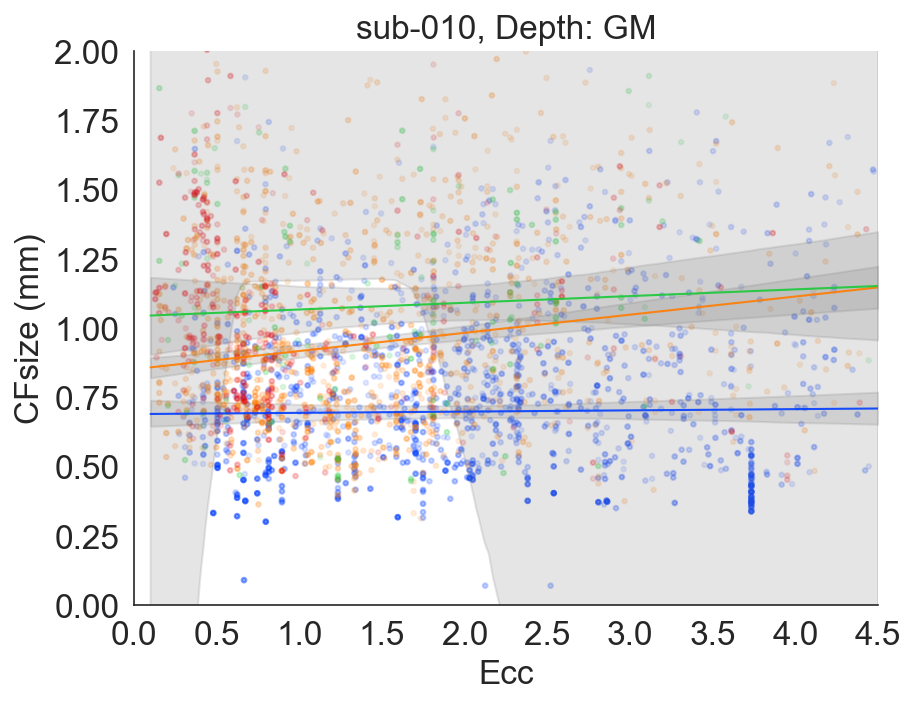

sub-012
0
1693


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1
1097


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2
145


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


3
340


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


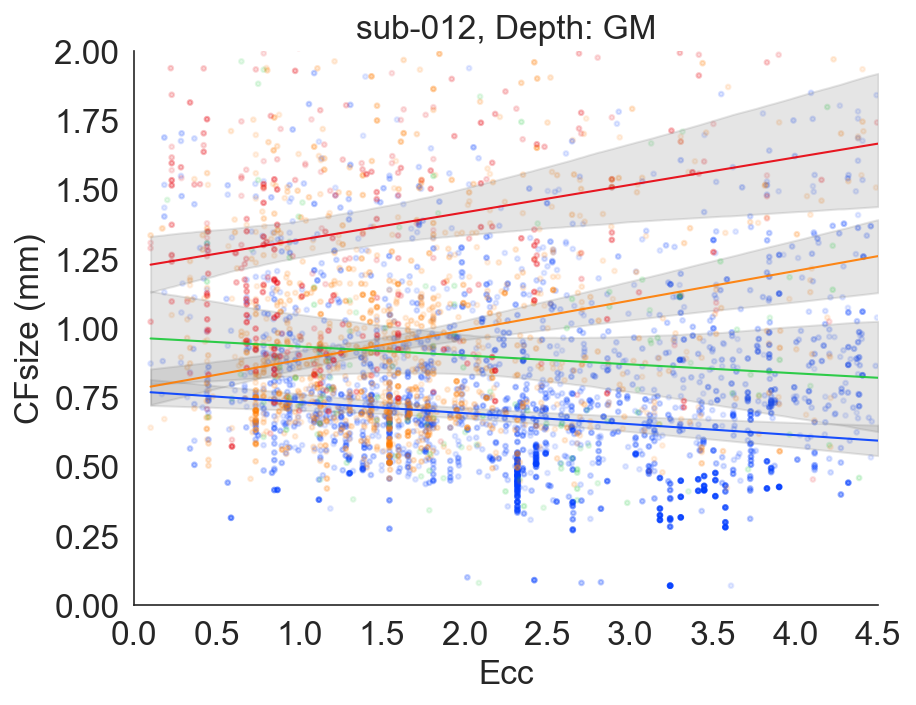

sub-013
0
1401


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1
1022


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2
291


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


3
386


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


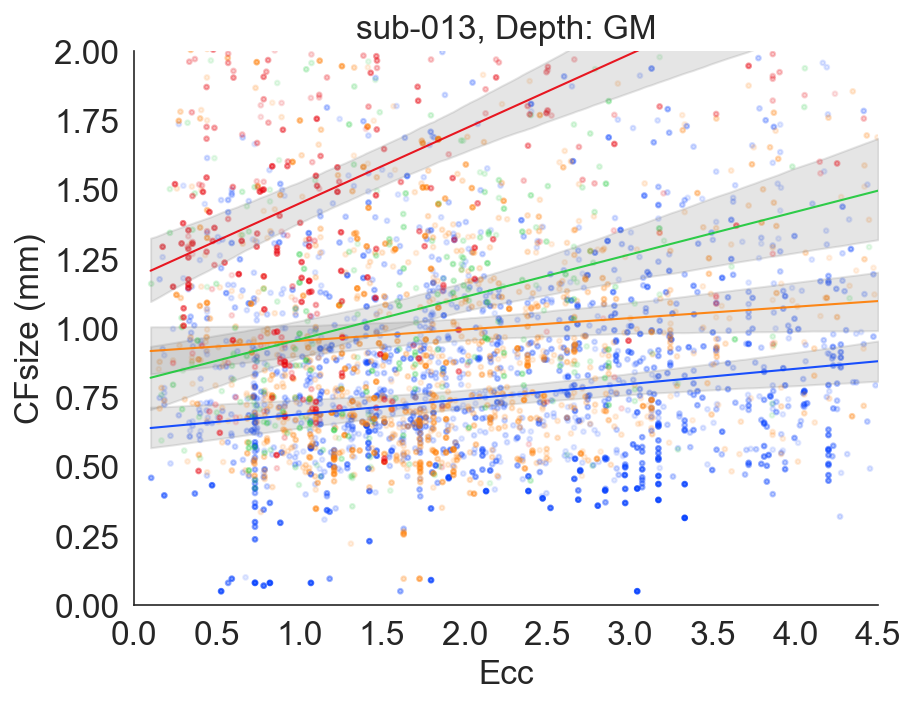

In [203]:
from importlib import reload
from utils import *
reload(utils)
pred_point=2
#Individual plots size x ecc per subject

for s in range(SUBJECTS.__len__()):
    print(subjectid[s])
    thickness=[]
    skip_subject = False
    for roi in range(target_list.__len__()):
        print(roi)
        mask_CFmodel(SUBJECTS[s].rois[roi].CFmodel,depth_list,r2_thr, ecc_bound, CFsize_bound)
        for d in range(depth_list.__len__()):
            ecc=SUBJECTS[s].rois[roi].CFmodel[d].CFcenter_ecc
            size=SUBJECTS[s].rois[roi].CFmodel[d].CFsize
            r2=SUBJECTS[s].rois[roi].CFmodel[d].r2
            print(ecc.__len__())
            if ecc.__len__()>20:
                try:
                    SUBJECTS[s].rois[roi].curve[d],SUBJECTS[s].rois[roi].curve_low[d],SUBJECTS[s].rois[roi].curve_up[d] = bs_scatter2weightedavg(ecc, size, r2, 2000, 0.95,ecc_bound,pred_point)
                except Exception as e:
                    print(f"Error in bs_scatter2weightedavg for Subject {subjectid[s]}, ROI {rois_list[0][roi]}, Depth {depth_list[d]}: {e}")
                    SUBJECTS[s].rois[roi].curve[d] = None
                    SUBJECTS[s].rois[roi].curve_low[d] = None
                    SUBJECTS[s].rois[roi].curve_up[d] = None
                    continue
            else:
                    SUBJECTS[s].rois[roi].curve[d] = None
                    SUBJECTS[s].rois[roi].curve_low[d] = None
                    SUBJECTS[s].rois[roi].curve_up[d] = None
                    #skip_subject=True
                    #break
            if skip_subject==True:
                break
            if depth_list[d]!='GM':
               dag_add_ax_basics(plt.gca(), xlabel='Eccentricity (deg)', ylabel='CFsize (mm)',title=f'{subjectid[s]}, {rois_list[0][roi]}, Depth: {str(float(depth_list[d])*100+6.25)}%')
            else:
                dag_add_ax_basics(plt.gca(), xlabel='Ecc', ylabel='CFsize (mm)',title=f'{subjectid[s]}, Depth: {str(depth_list[d])}')
            dag_update_ax_fontsize(plt.gca(), 16)
            dag_update_ax_dotsize(plt.gca(), 5)
            plt.xlim(0,ecc_bound[1]),
            plt.ylim([0,CFsize_bound[1]])
            try:
                print(rois_list[0][roi],np.nanmean(SUBJECTS[s].rois[roi].CFmodel[0].thickness))
            except:
                continue

    # Get the current figure and adjust its DPI
    fig = plt.gcf()
    plt.legend().remove()
    fig.set_dpi(150)
    #plt.show()
    #plt.plot(range(rois_list[0].__len__()),thickness)
    #plt.ylim([0,2.5])
    plt.show()